### Data display notebook
This notebook is used to cleanup and display the backtest data generated in the main notebook.

### Imports and variables

In [1]:
import pandas as pd
from matplotlib import pyplot
import seaborn as sns
import dask.dataframe as dd

# The framework used to generate the dataset, not the one used here!!
FRAMEWORK = "dask"
# FRAMEWORK = 'pandas'

### Utils

In [2]:
def get_sample(the_df):
    print(f"There are {len(the_df)} rows in the dataframe/series")
    try:
        res = the_df.sample(frac=5)
    except ValueError:
        res = the_df.sample(3)

    return res

### Load the dataframe

In [3]:
# If you want to work on backward optimizations, start running cells from here!
if FRAMEWORK == "dask":
    import glob

    path = r"forward_opt_results"  # use your path
    all_files = glob.glob(path + "/*.part")

    li = []

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    df = pd.concat(li, axis=0, ignore_index=True)
else:
    df = pd.read_csv("forward_opt_results.csv")

In [4]:
get_sample(df)

There are 1282 rows in the dataframe/series


,Unnamed: 0,uid,ticker,date,adx8,adx16,adx32,adx64,adx128,adx256,...,ppo256,ppo512,stochastic8,stochastic16,stochastic32,stochastic64,stochastic128,stochastic256,stochastic512,perc_change
257,5582,f9058014-ad7c-11eb-bb68-00155de4f607,ALK,2012-07-24,21.944934,13.957054,8.343866,4.873072,4.421294,5.057711,...,-1.105154,-10.263102,14.159195,17.486112,37.304328,56.832298,48.031496,69.014085,75.280899,-0.641026
345,5465,0daf1f2e-ade7-11eb-9938-00155d820499,AJG,2007-04-25,39.220934,21.461102,16.977152,10.806747,5.702270,3.038717,...,-0.356546,-1.842107,57.838828,61.245421,66.652452,79.912664,73.493976,82.493369,79.134860,3.690685
653,5059,8d4bf840-ade4-11eb-a086-00155d820499,APA,2011-03-10,17.500462,14.226303,12.561774,9.834251,5.666128,3.623339,...,-1.361166,-7.434883,20.303073,34.083961,58.713307,51.763908,77.649445,81.769231,89.123451,12.267810


## Backward optimizations

The idea with backward optimizations is to start from a set of indicators and find which one can be used to tune the strategy by finding patterns of trading.

### Time distributions

In [5]:
date_sorted_df = df.sort_values("date")

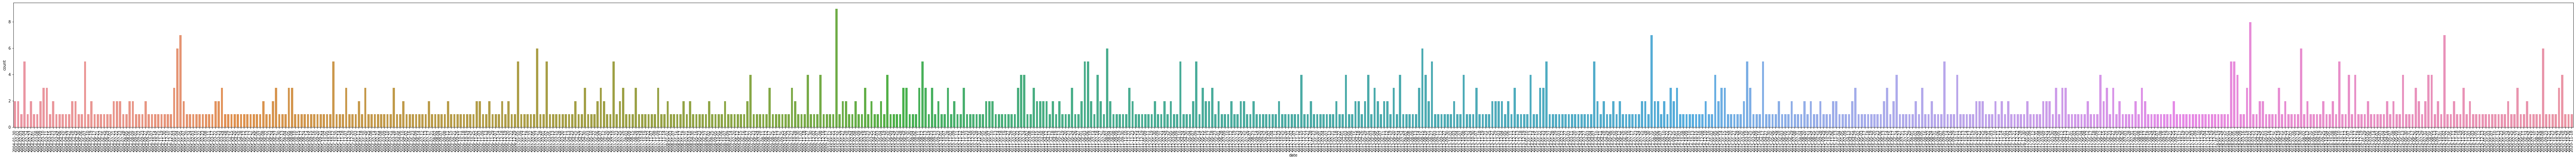

In [6]:
%matplotlib inline
# Let's see how trades are distributed over time
a4_dims = (120, 6)
fig, ax = pyplot.subplots(figsize=a4_dims)

sns.set_theme(style="dark")

ax = sns.countplot(ax=ax, x="date", data=date_sorted_df)
wtfx = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

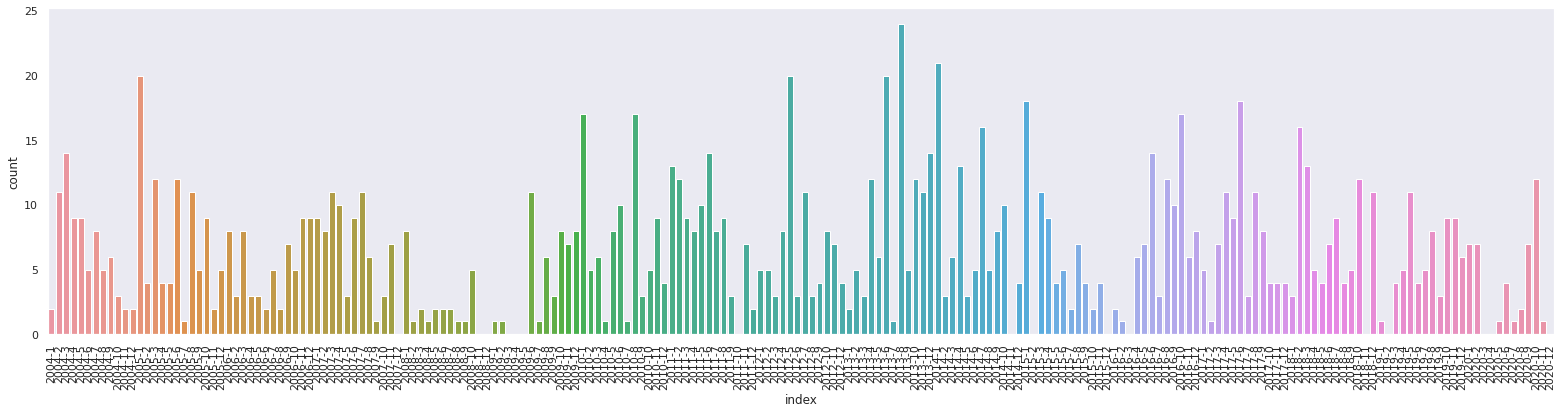

In [7]:
%matplotlib inline
# Find the frequency distribution of trades and also show each month, count trades in a month
min_year, min_month, _ = date_sorted_df.iloc[0]["date"].split("-")
max_year, max_month, _ = date_sorted_df.iloc[-1]["date"].split("-")
max_year, max_month, min_year, min_month = [
    int(x) for x in [max_year, max_month, min_year, min_month]
]

monthly_data = {}

for year in range(min_year, max_year + 1):
    for month in range(min_month, 13):
        fm = month if month >= 10 else f"0{month}"
        a = len(df[df["date"].str.startswith(f"{year}-{fm}")])
        monthly_data[f"{year}-{month}"] = a
    min_month = 1

monthly_df = pd.DataFrame(monthly_data, index=["count"]).transpose().reset_index()

a4_dims = (27, 6)
fig, ax = pyplot.subplots(figsize=a4_dims)

sns.set_theme(style="dark")

ax = sns.barplot(ax=ax, x="index", y="count", data=monthly_df)
wtfx = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

### Correlating values

In [6]:
# Add the 'is_profitable' column to better understand plots
df["is_profitable"] = df["perc_change"] >= 0

interactive(children=(Dropdown(description='var1', options=('adx', 'mdi', 'pdi', 'ppo', 'stochastic'), value='…

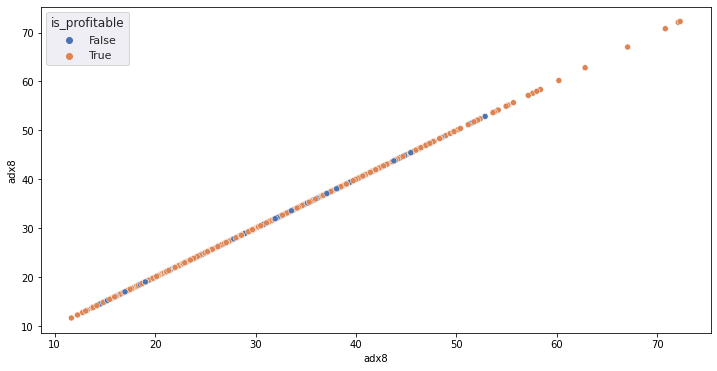

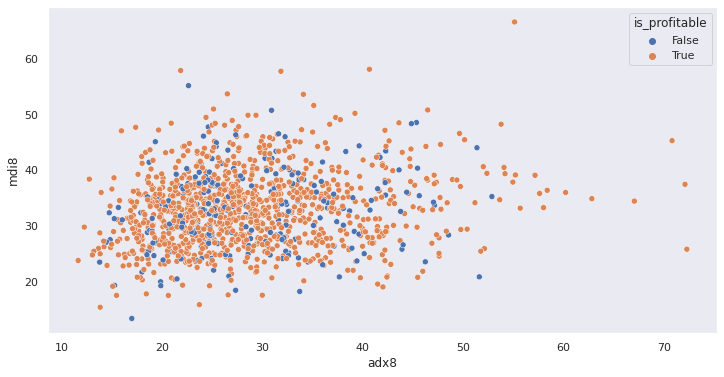

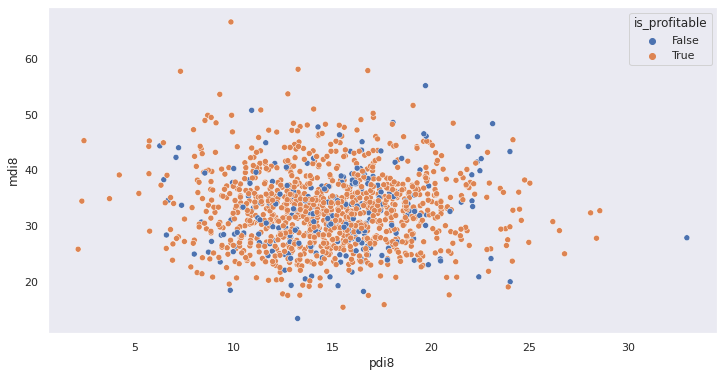

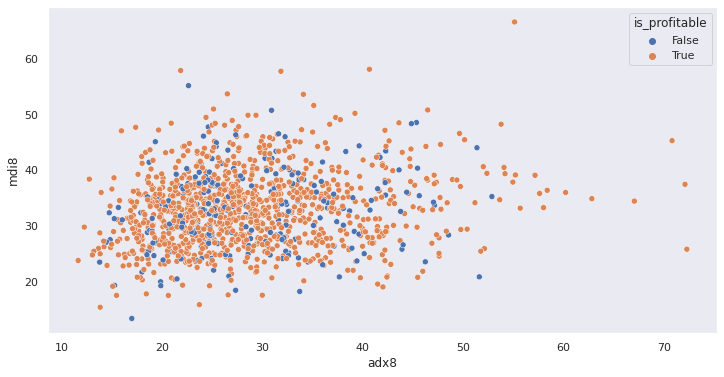

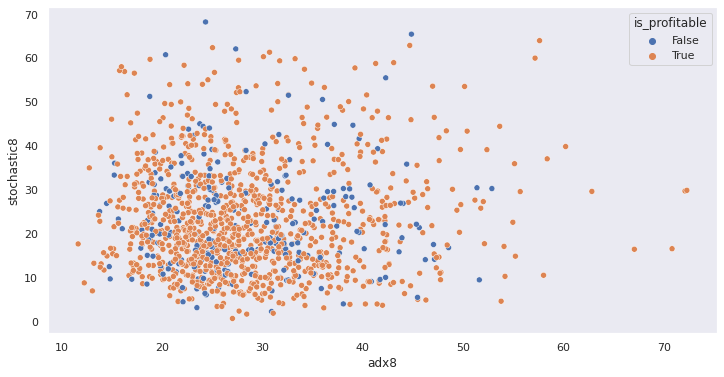

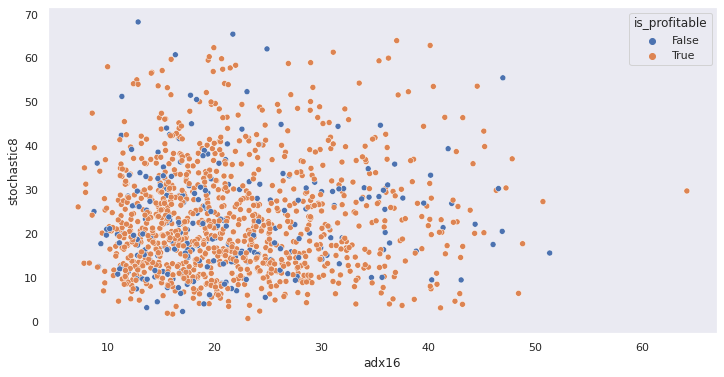

In [5]:
%matplotlib inline
# Plot manually 2D correlation graphs
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

metrics_options = ["adx", "mdi", "pdi", "ppo", "stochastic"]
size_options = [8, 16, 32, 64, 128, 256, 512]


@interact(
    var1=metrics_options, var2=metrics_options, size1=size_options, size2=size_options
)
def g(var1, var2, size1, size2):
    a4_dims = (12, 6)
    fig, ax = pyplot.subplots(figsize=a4_dims)

    sns.set_theme(style="dark")
    sns.scatterplot(
        ax=ax, data=df, x=f"{var1}{size1}", y=f"{var2}{size2}", hue="is_profitable"
    )

In [6]:
%matplotlib inline
# Plot manually 3D correlation graphs
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

metrics_options = ["adx", "mdi", "pdi", "ppo", "stochastic"]
size_options = [8, 16, 32, 64, 128, 256, 512]


@interact(
    show_good=True,
    show_bad=True,
    var1=metrics_options,
    var2=metrics_options,
    var3=metrics_options,
    size1=size_options,
    size2=size_options,
    size3=size_options,
)
def g(show_good, show_bad, var1, var2, var3, size1, size2, size3):
    pd.set_option("max_columns", 30)
    pd.set_option("max_rows", 10)

    fig = plt.figure(figsize=(16, 12), dpi=80)
    ax = fig.add_subplot(111, projection="3d")

    l1 = f"{var1}{size1}"
    l2 = f"{var2}{size2}"
    l3 = f"{var3}{size3}"

    if show_good:
        df21 = df[df["is_profitable"] == True]
        xs = df21[l1]
        ys = df21[l2]
        zs = df21[l3]
        ax.scatter(xs, ys, zs, c="r", marker="o")

    if show_bad:
        df21 = df[df["is_profitable"] == False]
        xs = df21[l1]
        ys = df21[l2]
        zs = df21[l3]
        ax.scatter(xs, ys, zs, c="b", marker="x")

    ax.set_xlabel(l1)
    ax.set_ylabel(l2)
    ax.set_zlabel(l3)

    plt.show()

interactive(children=(Checkbox(value=True, description='show_good'), Checkbox(value=True, description='show_ba…

<AxesSubplot:>

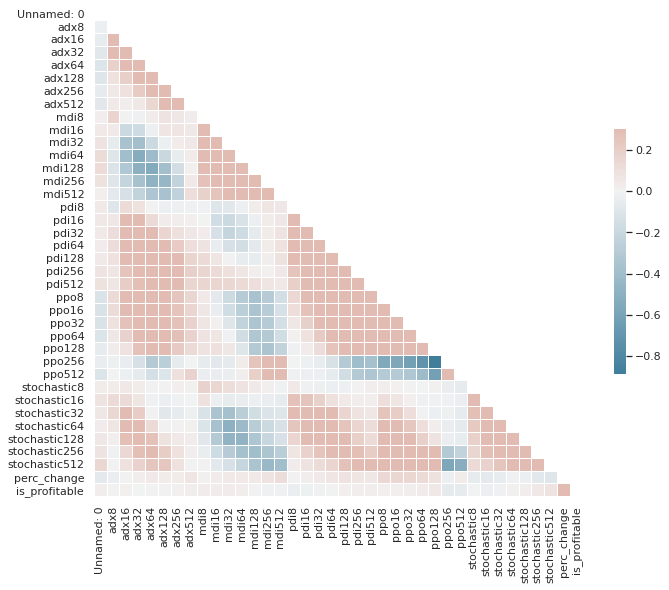

In [11]:
# Plot a heatmap correlation of indicators
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = df

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

In [ ]:
%matplotlib inline
# Plot lots of correlation graphs
import seaborn as sns

corr_columns = ["is_profitable", "adx8", "ppo8", "adx16"]

df_corr = df[corr_columns]

sns.set_theme(style="ticks")
sns.pairplot(df, corner=True, hue="is_profitable")

### Testing some stuff
After looking at the plots from before, I should be able to atleast find some mild optimizations for my strategy

### Utilities

In [43]:
def calculate_profitability(dfn):
    """Simple test for how many trades are profitable."""
    a = len(dfn)
    b = len(dfn[dfn["is_profitable"] == True])
    return b * 100 / a

### Get a feel for the data

In [ ]:
df.shape

In [ ]:
df.describe()

In [ ]:
df["perc_change"].mean()

In [ ]:
calculate_profitability(df)

### Average profitability by ticker

In [20]:
df1 = (
    df.groupby("ticker")["perc_change"]
    .apply(lambda x: (x > 0).sum())
    .reset_index(name="profitable")
)
df1["losing"] = (
    df.groupby("ticker")["perc_change"]
    .apply(lambda x: (x <= 0).sum())
    .reset_index(name="losing")["losing"]
)

In [21]:
df1["perc_profitable"] = df1["profitable"] / (df1["profitable"] + df1["losing"])
df1.sort_values("perc_profitable")

,ticker,profitable,losing,perc_profitable
4,ABBV,2,2,0.500000
26,ALLE,3,2,0.600000
18,AIG,9,5,0.642857
6,ABMD,21,10,0.677419
2,AAP,9,4,0.692308
38,AOS,18,8,0.692308
24,ALK,25,10,0.714286
43,ARE,22,8,0.733333
13,ADSK,25,9,0.735294
45,ATVI,24,8,0.750000


In [25]:
df1["ticker"].values

array(['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACN',
       'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL',
       'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE',
       'ALXN', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANSS',
       'ANTM', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO',
       'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO'], dtype=object)

In [31]:
df["date"].sort_values()

135     2004-01-30
638     2004-01-30
536     2004-02-02
891     2004-02-02
1084    2004-02-03
           ...    
777     2020-10-28
391     2020-10-28
769     2020-10-29
510     2020-10-30
1083    2020-11-18
Name: date, Length: 1282, dtype: object

### Stochastic8 over 45

In [17]:
tmp_df = df[df["stochastic8"] > 45]

In [18]:
calculate_profitability(tmp_df)

87.17948717948718

In [19]:
tmp_df.shape

(78, 41)

In [20]:
tmp_df.describe()

,Unnamed: 0,adx8,adx16,adx32,adx64,adx128,adx256,adx512,mdi8,mdi16,mdi32,mdi64,mdi128,mdi256,mdi512,...,ppo8,ppo16,ppo32,ppo64,ppo128,ppo256,ppo512,stochastic8,stochastic16,stochastic32,stochastic64,stochastic128,stochastic256,stochastic512,perc_change
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,...,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,5806.564103,30.417987,23.482794,17.453274,12.140286,8.706596,6.325195,4.491311,37.522563,29.211658,24.640617,22.622297,21.927215,21.868522,22.046363,...,10.863201,10.721966,9.624763,7.344217,3.759934,-1.192906,-6.792158,52.968869,52.464461,61.549518,70.768436,77.060875,81.548504,84.116196,4.646766
std,1379.532996,9.957416,8.964777,7.283958,4.529182,3.383531,2.822299,2.247828,6.778490,4.996745,3.755438,2.630215,1.915309,1.599058,1.449486,...,6.958106,6.621869,5.773877,4.429585,2.427820,0.859394,8.513570,5.707401,10.518803,17.689276,17.604133,13.494683,11.959557,14.425089,4.806633
min,2162.000000,14.990926,8.568150,7.420576,5.000435,3.663756,2.280704,1.171515,23.238442,19.328007,17.435709,16.433252,17.000666,18.590302,19.443300,...,1.255521,1.981698,1.449904,-1.389206,-2.740752,-4.549757,-26.320573,45.128205,27.143716,15.183211,13.800821,40.308568,35.484973,36.724022,-7.014418
25%,4997.250000,22.607057,16.419240,11.763764,9.310849,6.099767,4.121881,2.819748,33.327918,25.715778,22.011597,20.976438,20.418906,20.540891,21.004136,...,6.543217,6.356253,5.627694,4.457403,2.530226,-1.663713,-10.426838,48.220815,45.707268,50.848740,64.739235,71.400947,74.193361,83.336392,2.215024
50%,5862.000000,28.073858,21.051495,16.068958,10.880803,7.952295,5.816058,3.968007,36.433996,29.087487,24.490346,22.505459,21.933854,21.893228,21.924633,...,9.717679,9.760431,8.966391,6.804747,3.582596,-1.195908,-8.013808,51.999813,54.340081,67.829196,76.339039,80.309468,84.398286,89.182952,4.105056
75%,6701.000000,37.425763,29.133588,21.637720,13.623559,10.916437,7.887512,5.558565,41.925289,32.926037,27.405182,24.240541,22.922410,22.889992,22.875763,...,13.477055,13.160648,11.782186,9.402725,4.768842,-0.842654,-5.788034,57.470798,61.110963,74.812550,81.878317,87.610042,90.573101,93.057954,6.872000
max,8413.000000,57.602201,46.936677,42.715379,25.956079,22.860319,16.195368,11.921519,57.861237,43.560185,33.092472,27.968068,27.203822,27.156978,26.545623,...,40.814430,38.502571,32.017666,24.007103,13.860099,1.394645,39.121368,68.300654,68.718719,87.151390,92.134056,94.490280,94.688415,96.251437,17.462039


In [21]:
tmp_df["perc_change"].describe()

count    78.000000
mean      4.646766
std       4.806633
min      -7.014418
25%       2.215024
50%       4.105056
75%       6.872000
max      17.462039
Name: perc_change, dtype: float64

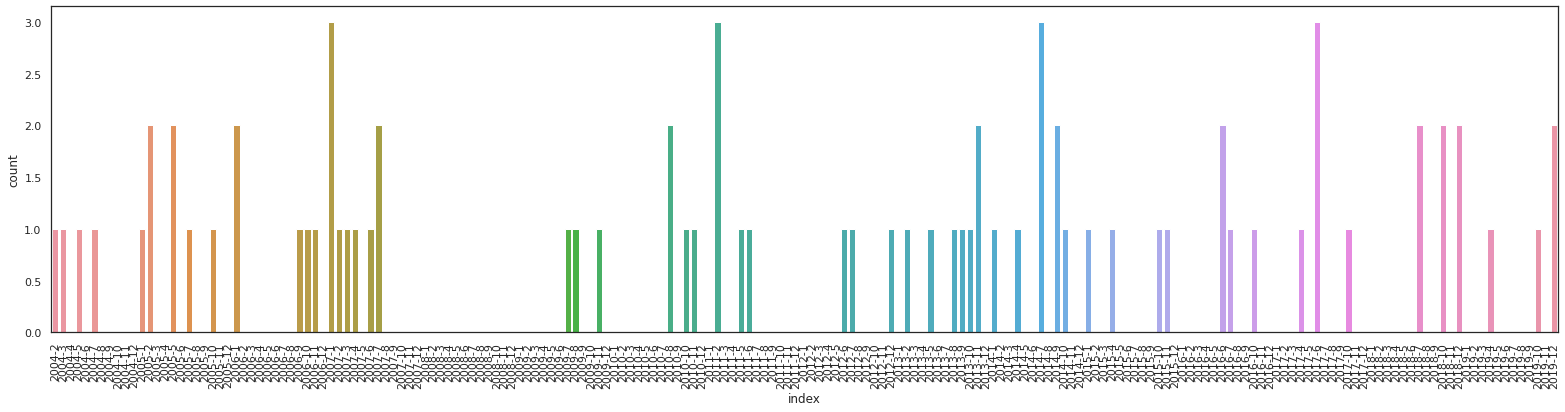

In [22]:
%matplotlib inline
# Find the frequency distribution of trades and also show each month, count trades in a month
date_sorted_df = tmp_df.sort_values("date")
min_year, min_month, _ = date_sorted_df.iloc[0]["date"].split("-")
max_year, max_month, _ = date_sorted_df.iloc[-1]["date"].split("-")
max_year, max_month, min_year, min_month = [
    int(x) for x in [max_year, max_month, min_year, min_month]
]

monthly_data = {}

for year in range(min_year, max_year + 1):
    for month in range(min_month, 13):
        fm = month if month >= 10 else f"0{month}"
        a = len(tmp_df[tmp_df["date"].str.startswith(f"{year}-{fm}")])
        monthly_data[f"{year}-{month}"] = a
    min_month = 1

monthly_df = pd.DataFrame(monthly_data, index=["count"]).transpose().reset_index()

a4_dims = (27, 6)
fig, ax = pyplot.subplots(figsize=a4_dims)

sns.set_theme(style="dark")

ax = sns.barplot(ax=ax, x="index", y="count", data=monthly_df)
wtfx = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

### Adx128 > 15

In [23]:
tmp_df = df[df["adx128"] > 15]

In [24]:
calculate_profitability(tmp_df)

85.29411764705883

In [25]:
tmp_df.shape

(102, 41)

In [26]:
tmp_df.describe()

,Unnamed: 0,adx8,adx16,adx32,adx64,adx128,adx256,adx512,mdi8,mdi16,mdi32,mdi64,mdi128,mdi256,mdi512,...,ppo8,ppo16,ppo32,ppo64,ppo128,ppo256,ppo512,stochastic8,stochastic16,stochastic32,stochastic64,stochastic128,stochastic256,stochastic512,perc_change
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,...,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,5054.147059,30.096459,24.971469,23.832682,22.273321,17.589180,11.085719,6.542234,33.158994,26.693060,22.699649,20.504096,19.688991,19.912149,20.697876,...,19.779821,20.233770,19.079220,15.221811,7.688487,-2.065200,-7.870213,22.563018,28.140217,43.917579,59.461712,75.069339,83.105620,85.966151,7.309765
std,1687.482831,10.132837,9.994257,8.172446,5.240840,2.064170,2.598960,2.851758,6.838219,4.908184,3.732892,2.794351,2.276074,2.043076,1.921617,...,15.936595,15.748229,14.444249,11.945239,8.034830,4.590788,47.895690,10.645933,14.224046,20.304670,21.131759,12.335513,8.512872,13.521878,10.555126
min,839.000000,15.788125,11.201970,7.991607,9.699330,15.005804,6.255804,2.360057,19.451915,15.867610,13.982676,13.797334,15.429126,17.000689,17.662137,...,-55.930453,-54.922724,-53.471559,-53.863591,-50.406066,-5.627423,-29.046806,4.742515,4.443225,4.443225,6.172819,35.448015,53.106061,2.282192,-14.939024
25%,3742.250000,23.004760,16.302757,18.018709,18.768724,15.970077,9.161096,4.773160,28.000193,22.271053,19.724443,18.937619,18.256694,18.747001,19.743034,...,10.802622,11.823972,11.764045,9.805552,5.641566,-3.197955,-18.314975,14.770475,16.067762,27.451563,47.802691,69.426579,79.841857,83.587560,2.657481
50%,5573.000000,27.392945,22.702928,22.592232,22.529934,16.886238,10.801466,5.729569,33.528705,27.092852,23.137187,20.327965,19.247996,19.492491,20.429629,...,17.417945,17.279548,16.437606,13.127945,6.984356,-2.273391,-14.077412,20.238346,28.178786,43.869841,63.341475,77.595446,85.020995,89.254869,6.092920
75%,6089.500000,35.948906,32.660160,29.355631,25.621811,18.961461,12.490863,7.450939,37.303428,29.683017,25.290220,22.198087,20.796835,20.440120,21.132923,...,26.548593,27.210356,25.214921,19.634815,10.315473,-1.867175,-11.352310,30.167535,36.560151,62.013004,77.441825,83.498477,88.984483,92.589936,10.061349
max,9260.000000,72.266146,48.779531,47.006788,33.596331,24.446003,20.527526,18.550530,48.562435,39.603891,32.903468,27.968068,29.858642,30.336220,28.381209,...,70.505780,69.075092,60.701732,44.240902,22.311181,32.575458,339.770031,59.605272,63.663843,78.779956,86.089907,90.046083,93.878463,95.527261,69.523810


In [27]:
tmp_df["perc_change"].describe()

count    102.000000
mean       7.309765
std       10.555126
min      -14.939024
25%        2.657481
50%        6.092920
75%       10.061349
max       69.523810
Name: perc_change, dtype: float64

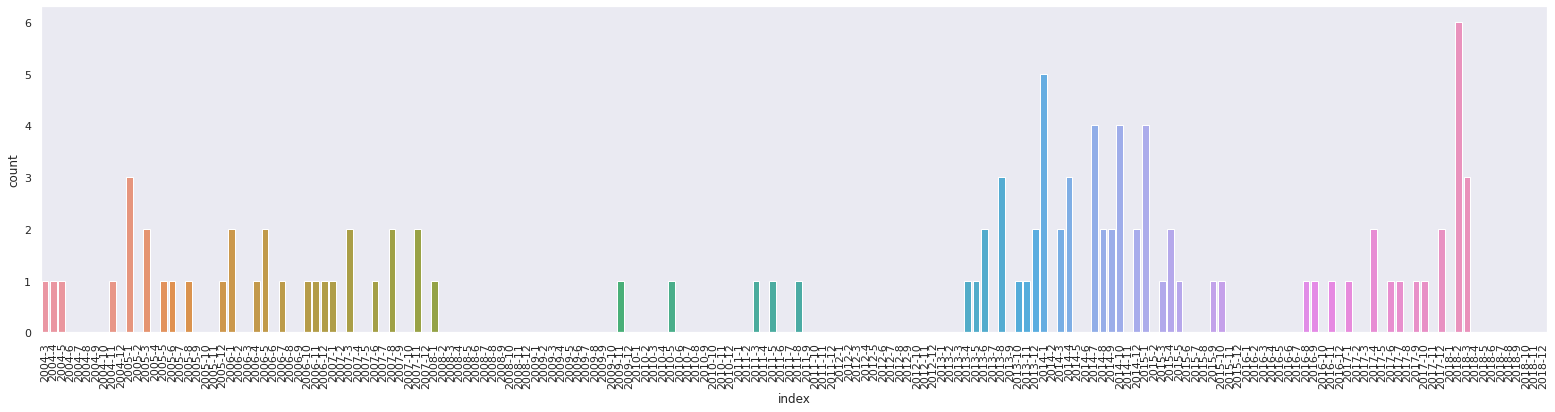

In [28]:
%matplotlib inline
# Find the frequency distribution of trades and also show each month, count trades in a month
date_sorted_df = tmp_df.sort_values("date")
min_year, min_month, _ = date_sorted_df.iloc[0]["date"].split("-")
max_year, max_month, _ = date_sorted_df.iloc[-1]["date"].split("-")
max_year, max_month, min_year, min_month = [
    int(x) for x in [max_year, max_month, min_year, min_month]
]

monthly_data = {}

for year in range(min_year, max_year + 1):
    for month in range(min_month, 13):
        fm = month if month >= 10 else f"0{month}"
        a = len(tmp_df[tmp_df["date"].str.startswith(f"{year}-{fm}")])
        monthly_data[f"{year}-{month}"] = a
    min_month = 1

monthly_df = pd.DataFrame(monthly_data, index=["count"]).transpose().reset_index()

a4_dims = (27, 6)
fig, ax = pyplot.subplots(figsize=a4_dims)

sns.set_theme(style="dark")

ax = sns.barplot(ax=ax, x="index", y="count", data=monthly_df)
wtfx = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

### PPO8 > 25

In [29]:
tmp_df = df[df["ppo8"] > 25]

In [30]:
calculate_profitability(tmp_df)

83.33333333333333

In [31]:
tmp_df.shape

(78, 41)

In [32]:
tmp_df.describe()

,Unnamed: 0,adx8,adx16,adx32,adx64,adx128,adx256,adx512,mdi8,mdi16,mdi32,mdi64,mdi128,mdi256,mdi512,...,ppo8,ppo16,ppo32,ppo64,ppo128,ppo256,ppo512,stochastic8,stochastic16,stochastic32,stochastic64,stochastic128,stochastic256,stochastic512,perc_change
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,...,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,4742.987179,32.160560,28.860603,26.402831,20.582509,13.472605,8.149452,5.522681,33.945873,26.453195,22.227835,20.371617,20.003204,20.667228,21.666265,...,34.787479,34.892992,31.303511,23.103029,10.862084,-2.877416,-10.209273,24.244924,31.402092,54.132941,70.750945,79.801373,83.977206,84.467429,10.720591
std,1442.372932,9.825142,10.739568,8.153117,5.936122,4.335845,3.144658,3.770339,6.476274,4.855700,3.675584,2.633436,1.861507,1.737379,1.956638,...,10.381225,10.318774,9.612303,8.006531,4.403316,1.449911,18.458379,12.162032,13.529176,17.069892,12.356611,7.078801,5.426218,10.074502,14.740090
min,839.000000,16.933296,11.201970,9.176312,6.210715,4.147589,2.947265,1.171515,20.221271,15.176278,13.716236,13.797334,15.429126,17.673369,18.979260,...,25.038016,23.484495,13.738889,1.677130,-3.389993,-5.627423,-29.046806,2.491151,8.985354,8.927203,14.757038,58.345221,70.954606,28.756674,-17.516081
25%,4019.500000,25.012814,20.671753,21.630707,16.365582,10.271680,5.742983,2.997598,29.904413,22.526251,19.264999,18.686966,18.748285,19.593069,20.604541,...,27.882610,28.146616,25.279388,18.436665,8.392312,-3.804597,-19.787165,15.258356,21.093876,44.882336,63.435604,74.487056,80.261864,82.378359,2.982871
50%,5136.000000,30.891417,27.516948,26.844896,19.874687,13.560976,7.828900,4.771606,33.836332,26.997021,22.374532,20.547819,19.971295,20.354453,21.248708,...,31.538619,31.983923,28.789414,21.607774,10.161206,-2.890526,-15.715589,22.919440,29.790237,56.256948,72.648357,80.981424,84.195429,86.891445,8.115636
75%,5750.500000,37.997496,35.951374,31.392510,24.739443,16.516050,10.808028,6.253448,38.243396,29.754520,24.880732,22.112575,21.177803,21.453475,22.178825,...,38.548677,38.294587,35.628408,26.493767,12.725561,-2.244120,-9.935824,31.849685,40.723440,68.322608,80.288575,84.769133,88.184559,89.841391,16.688584
max,7748.000000,72.081898,64.129522,49.543935,33.295145,24.446003,15.852871,18.757521,50.976783,37.667909,30.778862,26.288135,23.714766,25.567701,28.359433,...,72.482257,73.785559,67.993330,51.381053,23.421182,2.246541,70.264273,59.933528,63.628134,78.508772,87.291424,91.147153,93.232597,95.010949,69.523810


In [33]:
tmp_df["perc_change"].describe()

count    78.000000
mean     10.720591
std      14.740090
min     -17.516081
25%       2.982871
50%       8.115636
75%      16.688584
max      69.523810
Name: perc_change, dtype: float64

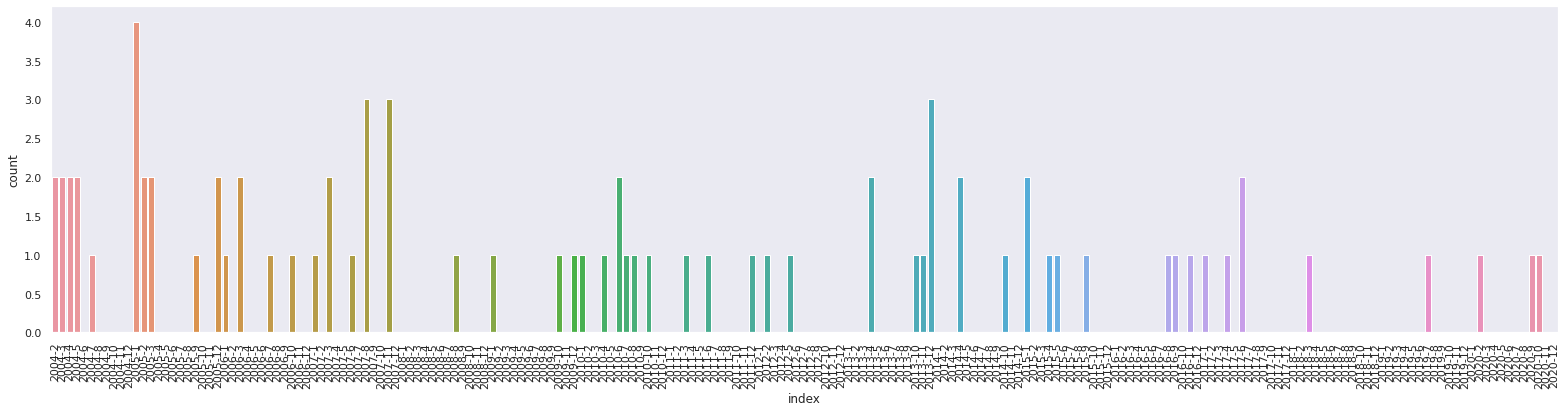

In [34]:
%matplotlib inline
# Find the frequency distribution of trades and also show each month, count trades in a month
date_sorted_df = tmp_df.sort_values("date")
min_year, min_month, _ = date_sorted_df.iloc[0]["date"].split("-")
max_year, max_month, _ = date_sorted_df.iloc[-1]["date"].split("-")
max_year, max_month, min_year, min_month = [
    int(x) for x in [max_year, max_month, min_year, min_month]
]

monthly_data = {}

for year in range(min_year, max_year + 1):
    for month in range(min_month, 13):
        fm = month if month >= 10 else f"0{month}"
        a = len(tmp_df[tmp_df["date"].str.startswith(f"{year}-{fm}")])
        monthly_data[f"{year}-{month}"] = a
    min_month = 1

monthly_df = pd.DataFrame(monthly_data, index=["count"]).transpose().reset_index()

a4_dims = (27, 6)
fig, ax = pyplot.subplots(figsize=a4_dims)

sns.set_theme(style="dark")

ax = sns.barplot(ax=ax, x="index", y="count", data=monthly_df)
wtfx = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

### STOCCHASTIC64 < 50

In [35]:
tmp_df = df[df["stochastic64"] < 50]

In [36]:
calculate_profitability(tmp_df)

80.25078369905957

In [37]:
tmp_df.shape

(319, 41)

In [38]:
tmp_df.describe()

,Unnamed: 0,adx8,adx16,adx32,adx64,adx128,adx256,adx512,mdi8,mdi16,mdi32,mdi64,mdi128,mdi256,mdi512,...,ppo8,ppo16,ppo32,ppo64,ppo128,ppo256,ppo512,stochastic8,stochastic16,stochastic32,stochastic64,stochastic128,stochastic256,stochastic512,perc_change
count,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,...,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
mean,5629.470219,27.918813,17.734442,13.422599,11.614369,8.950855,6.154615,4.399333,33.785919,28.842747,25.534550,23.276601,22.252433,22.123158,22.314194,...,6.704055,7.547735,8.024444,7.373463,4.123852,-1.195991,-5.112294,20.193988,22.801290,28.881649,31.718718,55.472573,71.587857,74.643562,5.348306
std,1533.027973,9.602378,6.019455,4.824621,4.914927,3.931693,2.792883,2.331214,6.028164,4.330785,3.147774,2.359820,1.922958,1.748329,1.633853,...,6.547613,6.677042,6.595481,6.021360,4.333678,2.453063,26.536429,10.851992,12.571177,15.300558,13.278885,13.493426,9.064938,14.333073,8.174686
min,586.000000,11.661290,7.802343,5.317985,3.772448,2.985051,2.280343,0.970487,19.412815,18.724966,18.292980,17.925247,17.568637,17.957475,18.803071,...,-55.930453,-54.922724,-53.471559,-53.863591,-50.406066,-4.774604,-26.320573,1.805003,1.169906,0.649494,1.178551,15.034965,28.581174,2.282192,-17.941953
25%,4829.000000,21.500094,13.361235,10.042638,8.093959,6.001115,4.143422,2.948293,29.311399,25.819538,23.271396,21.616856,20.853766,20.773289,21.134536,...,3.468892,4.091731,4.677173,4.580909,2.592665,-1.884298,-11.241304,12.661496,14.129017,15.998269,21.250363,46.123942,66.869519,71.100706,0.917312
50%,5869.000000,26.146923,16.639564,12.829095,10.475270,7.984962,5.560528,3.918164,33.858486,28.629317,25.562784,23.381471,22.183249,22.104031,22.123044,...,5.838488,6.674162,6.955698,6.636824,3.888117,-1.359743,-8.660388,17.908018,19.706226,28.219178,34.292566,55.638351,72.447013,78.760393,4.792561
75%,6653.000000,32.640358,20.699439,15.918634,13.755073,11.022901,7.373698,5.167490,37.618194,31.845370,27.862543,25.000402,23.609884,23.359178,23.312455,...,8.970508,9.736245,10.220037,9.011439,5.379076,-0.813906,-4.842366,26.264784,29.965385,39.962140,43.076688,66.420627,78.431436,83.285489,9.120223
max,8803.000000,72.266146,46.315652,36.195687,33.295145,22.860319,20.527526,18.404319,50.976783,41.522349,34.442248,28.957914,29.858642,30.336220,28.381209,...,36.293253,37.670633,36.703849,32.837649,18.868420,32.575458,307.814843,60.073260,63.663843,73.673036,50.000000,81.637049,88.946205,92.391601,69.523810


In [43]:
tmp_df.sort_values("perc_change")

,Unnamed: 0,uid,ticker,date,adx8,adx16,adx32,adx64,adx128,adx256,adx512,mdi8,mdi16,mdi32,mdi64,...,ppo16,ppo32,ppo64,ppo128,ppo256,ppo512,stochastic8,stochastic16,stochastic32,stochastic64,stochastic128,stochastic256,stochastic512,perc_change,is_profitable
436,5375,c21292a8-ad73-11eb-b09e-00155de4f607,ABMD,2011-08-02,18.552773,12.797722,11.394342,13.370930,9.528567,4.854291,2.539131,28.892595,24.635819,22.991485,21.814510,...,15.120383,16.264427,15.490942,8.783236,-2.602444,-12.096910,15.184852,15.184852,29.218081,15.688954,64.699684,68.276515,72.808442,-17.941953,False
973,5165,7e13618a-ade7-11eb-9916-00155d820499,AIZ,2020-02-27,30.915930,17.014723,13.939153,17.104036,13.014357,7.137172,4.618734,50.748404,39.850913,32.257381,26.584963,...,11.750028,10.986889,9.205367,5.226815,-1.679526,-9.965333,2.397242,11.317622,30.463144,30.463144,54.027406,79.036382,82.374339,-17.484094,False
655,5147,8d9c9584-ade4-11eb-a086-00155d820499,APA,2011-08-02,21.568872,12.799057,7.763376,5.420008,3.859618,3.047416,3.025629,30.520183,26.195766,24.553058,23.896173,...,6.215467,5.545563,4.999373,3.399899,-1.285905,-8.206480,17.501479,32.697656,53.487095,42.715383,50.010535,76.812640,80.811098,-14.122738,False
1137,5758,c89ac55a-ad78-11eb-87e0-00155de4f607,AES,2011-07-18,25.508295,14.425787,7.563533,5.047878,3.272286,3.437196,4.516578,34.561342,27.792593,24.427156,22.706175,...,2.482759,2.362774,2.472221,1.663237,-0.472647,-0.189122,11.730769,37.116105,37.407407,31.464174,31.609195,71.462830,55.120678,-11.497890,False
1194,5792,c19ba29a-ade8-11eb-94db-00155d820499,ADSK,2012-05-09,27.832799,17.267728,14.226670,9.836770,6.112371,3.755975,2.791086,39.000111,33.623103,28.393898,25.813199,...,6.880221,8.304873,6.705325,2.588534,-0.663731,-4.677413,15.698501,14.070676,12.576137,19.335265,55.023184,59.930915,59.930915,-10.923913,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1209,6895,c4a861a8-ade8-11eb-94db-00155d820499,ADSK,2018-07-30,19.785589,11.387204,6.990633,5.129251,5.503004,5.640103,3.993305,35.744745,30.245534,26.818960,24.771699,...,8.536193,8.867234,8.079039,4.927230,-1.936259,-14.084134,34.829587,34.870710,33.006130,39.629241,72.199404,72.199404,86.641901,23.472441,True
660,5543,8f2c7d88-ade4-11eb-a086-00155d820499,APA,2016-08-31,20.197978,9.710174,5.527988,5.397016,4.809332,4.839817,4.476298,30.815470,25.680177,24.190159,23.672718,...,1.368815,1.973961,2.623730,0.756775,0.639645,10.328840,28.088226,57.935628,40.625595,33.341820,66.019374,72.024771,29.540059,28.507795,True
188,6450,687d8820-ade5-11eb-aa54-00155d820499,AMAT,2020-10-26,24.874423,14.015207,8.750453,6.756413,6.659296,5.634784,4.874067,35.375634,27.747578,24.915400,23.645384,...,7.035323,6.381808,5.713747,3.505669,-1.325410,-9.161900,13.582951,33.092712,58.281296,42.314335,62.371497,73.116008,78.532980,39.800743,True
8,4497,1ad50e86-ad77-11eb-8c7b-00155de4f607,AMD,2009-08-11,11.661290,10.948898,10.219601,8.768275,8.763688,8.615150,3.946412,23.861743,25.247242,24.829370,23.279087,...,-6.705370,-5.353261,-5.126077,-7.455496,6.120006,68.889327,17.777778,29.365079,42.394822,25.992063,57.126437,41.993127,15.535215,49.860724,True


In [39]:
tmp_df["perc_change"].describe()

count    319.000000
mean       5.348306
std        8.174686
min      -17.941953
25%        0.917312
50%        4.792561
75%        9.120223
max       69.523810
Name: perc_change, dtype: float64

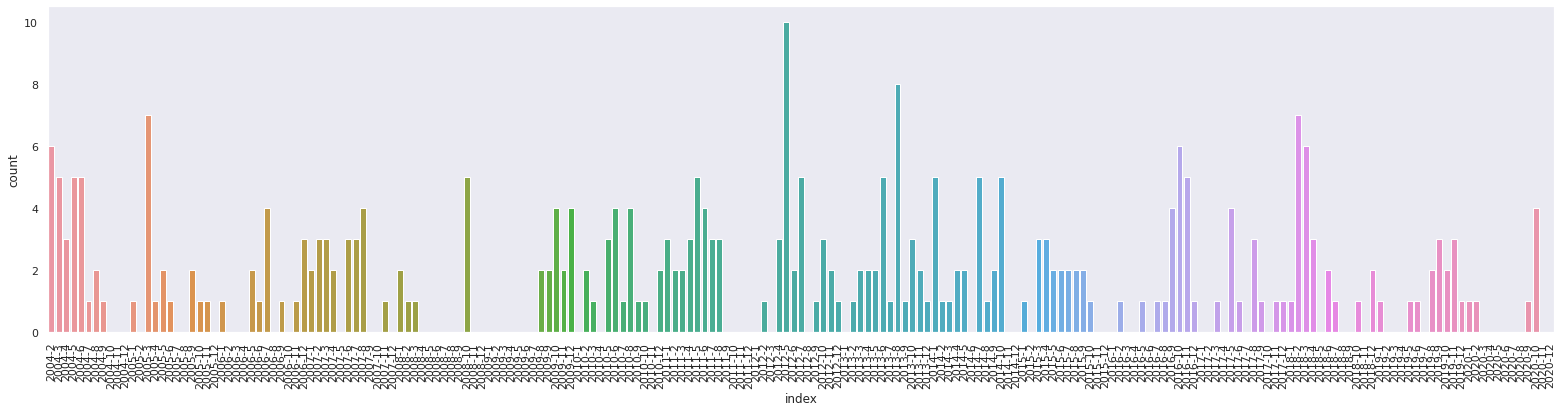

In [40]:
%matplotlib inline
# Find the frequency distribution of trades and also show each month, count trades in a month
date_sorted_df = tmp_df.sort_values("date")
min_year, min_month, _ = date_sorted_df.iloc[0]["date"].split("-")
max_year, max_month, _ = date_sorted_df.iloc[-1]["date"].split("-")
max_year, max_month, min_year, min_month = [
    int(x) for x in [max_year, max_month, min_year, min_month]
]

monthly_data = {}

for year in range(min_year, max_year + 1):
    for month in range(min_month, 13):
        fm = month if month >= 10 else f"0{month}"
        a = len(tmp_df[tmp_df["date"].str.startswith(f"{year}-{fm}")])
        monthly_data[f"{year}-{month}"] = a
    min_month = 1

monthly_df = pd.DataFrame(monthly_data, index=["count"]).transpose().reset_index()

a4_dims = (27, 6)
fig, ax = pyplot.subplots(figsize=a4_dims)

sns.set_theme(style="dark")

ax = sns.barplot(ax=ax, x="index", y="count", data=monthly_df)
wtfx = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [49]:
df.sort_values("perc_change").head(10)[["ticker", "date", "perc_change"]]

,ticker,date,perc_change
1152,AES,2020-02-24,-37.468096
246,ALK,2009-02-20,-27.655678
436,ABMD,2011-08-02,-17.941953
2,AMD,2005-01-04,-17.516081
973,AIZ,2020-02-27,-17.484094
840,ABBV,2020-02-26,-16.487758
838,ABBV,2018-03-19,-14.939024
655,APA,2011-08-02,-14.122738
1188,ADSK,2008-01-02,-13.018242
441,ABMD,2013-09-12,-12.566138


### Breakdowns by period
How do the optimized parameters fair over time?

In [62]:
df["year"] = df["date"].str.split("-").apply(lambda x: int(x[0][2:]))
df["month"] = df["date"].str.split("-").apply(lambda x: int(x[1]))
df["pperc_change"] = abs(df["perc_change"])
df = df.sort_values("date")
# df['pperc_change']

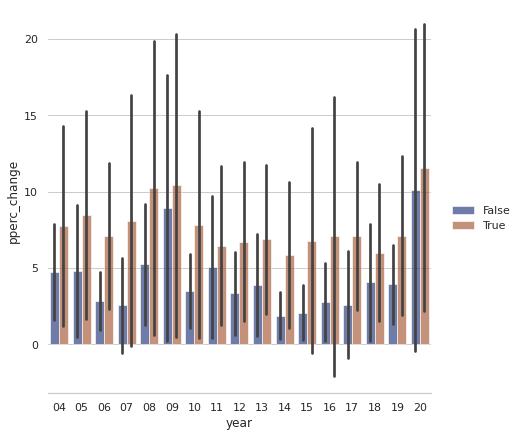

In [35]:
import seaborn as sns

sns.set_theme(style="whitegrid")

penguins = sns.load_dataset("penguins")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df,
    kind="bar",
    x="year",
    y="pperc_change",
    hue="is_profitable",
    ci="sd",
    palette="dark",
    alpha=0.6,
    height=6,
)
g.despine(left=True)
# g.set_axis_labels("", "Body mass (g)")
g.legend.set_title("")

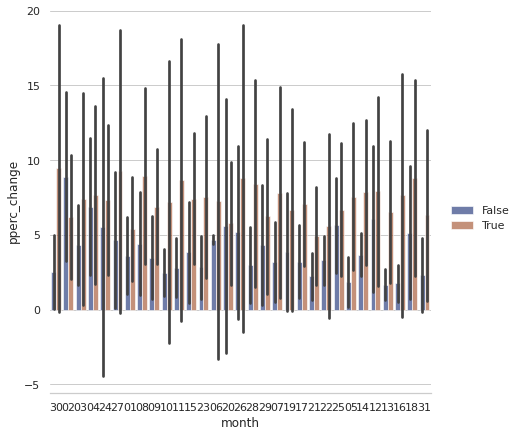

In [38]:
import seaborn as sns

sns.set_theme(style="whitegrid")

penguins = sns.load_dataset("penguins")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df,
    kind="bar",
    x="month",
    y="pperc_change",
    hue="is_profitable",
    ci="sd",
    palette="dark",
    alpha=0.6,
    height=6,
)
g.despine(left=True)
# g.set_axis_labels("", "Body mass (g)")
g.legend.set_title("")

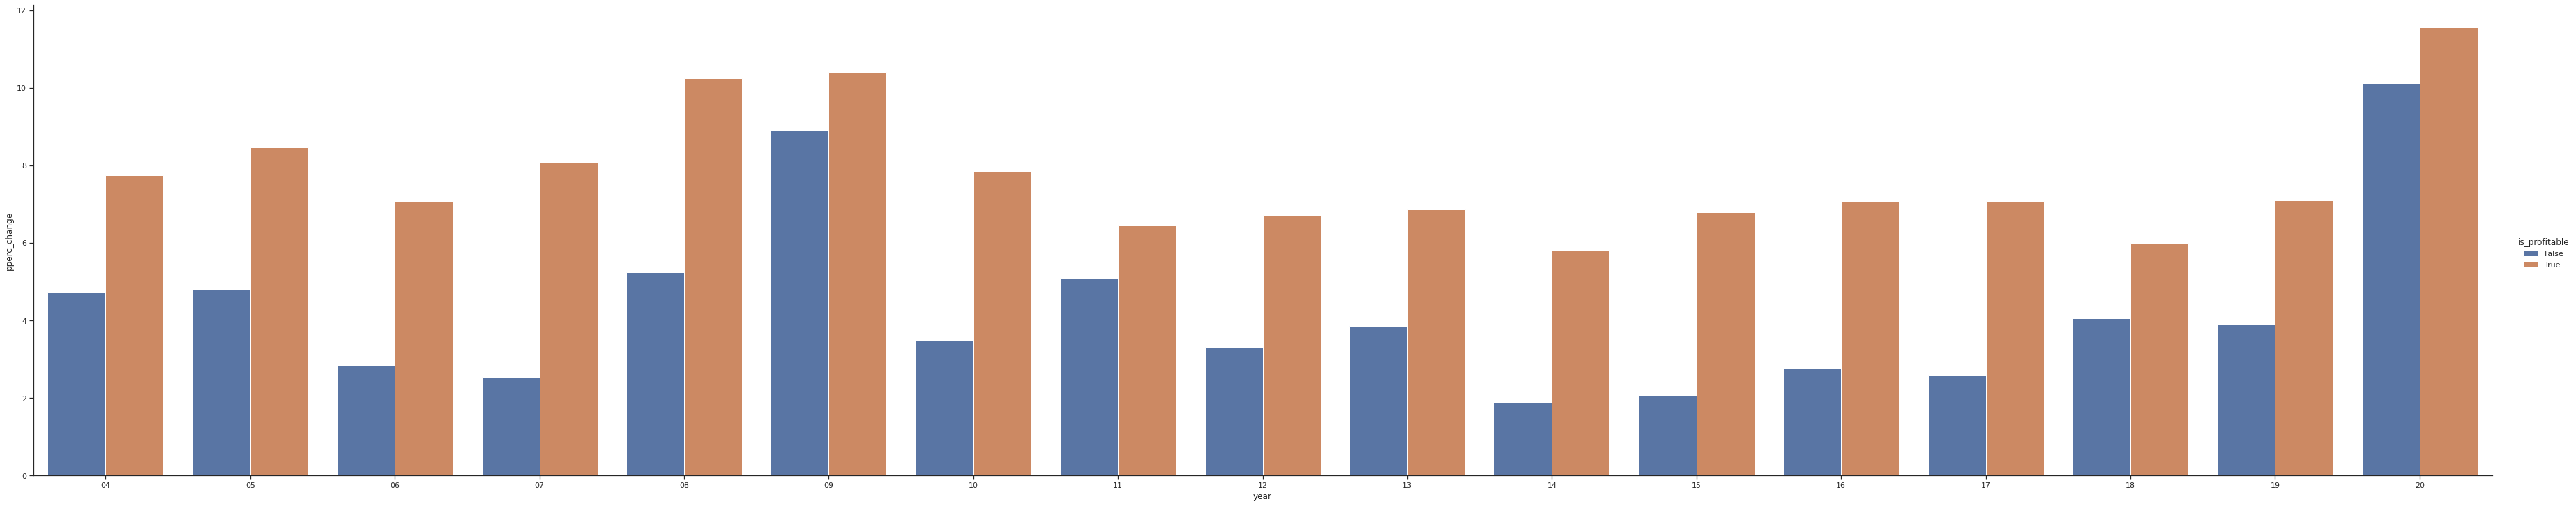

In [49]:
import seaborn as sns

sns.set_theme(style="ticks")
g = sns.catplot(
    x="year",
    y="pperc_change",
    hue="is_profitable",
    kind="bar",
    ci=None,
    data=df,
    height=10,
    aspect=5,
)

In [ ]:
import seaborn as sns

sns.set_theme(style="ticks")
g = sns.catplot(
    row="year",
    x="month",
    y="pperc_change",
    hue="is_profitable",
    kind="bar",
    orient="h",
    ci=None,
    data=df.sort_values("date"),
    height=10,
    aspect=5,
)

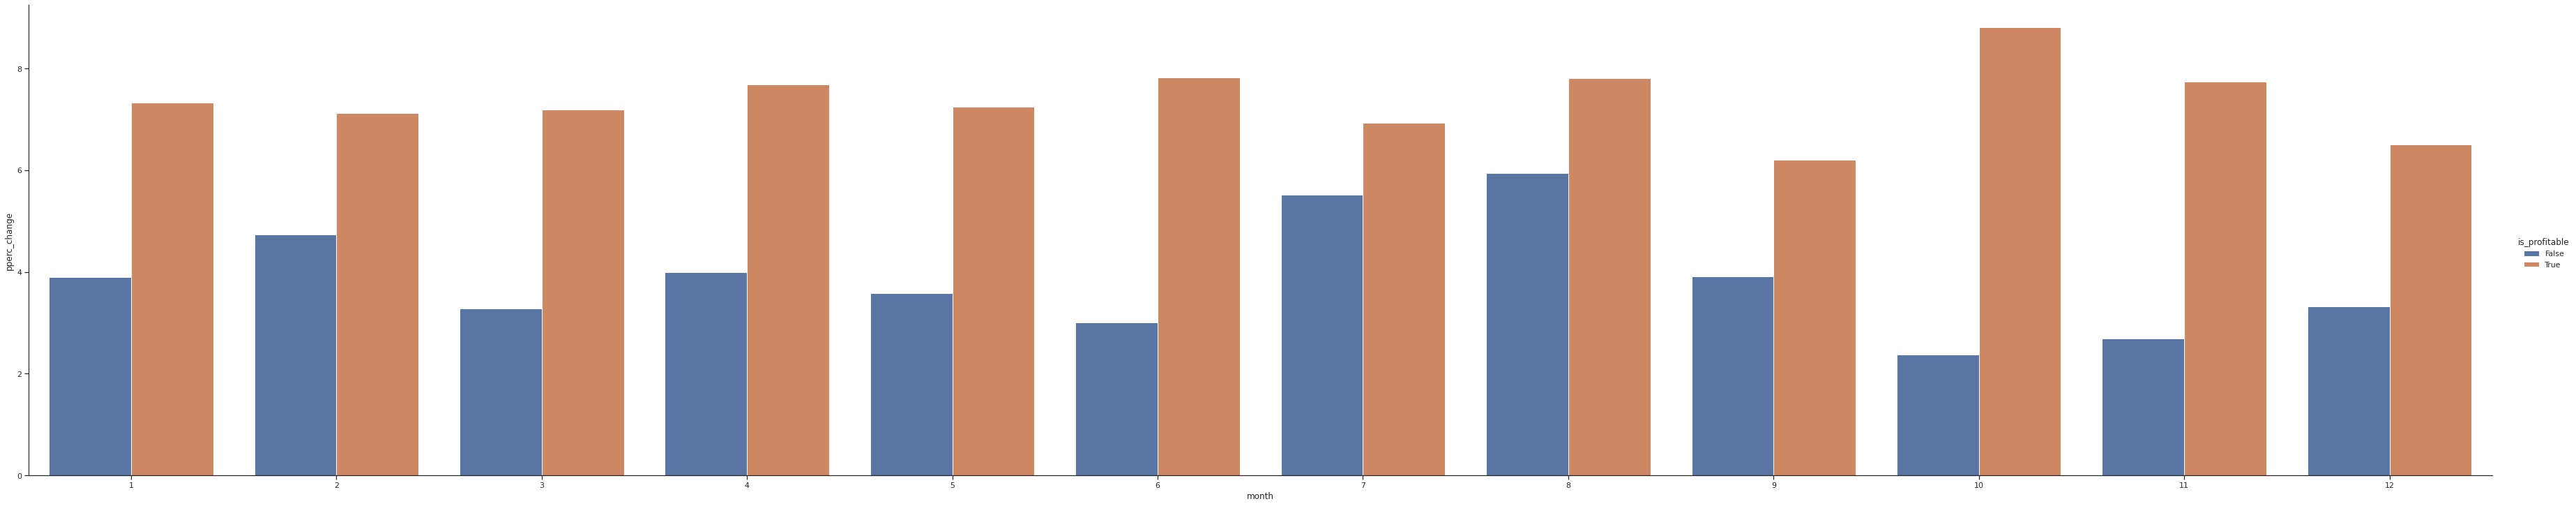

In [63]:
import seaborn as sns

sns.set_theme(style="ticks")
g = sns.catplot(
    x="month",
    y="pperc_change",
    hue="is_profitable",
    kind="bar",
    ci=None,
    data=df[df["year"] < 15].sort_values("date"),
    height=10,
    aspect=5,
)

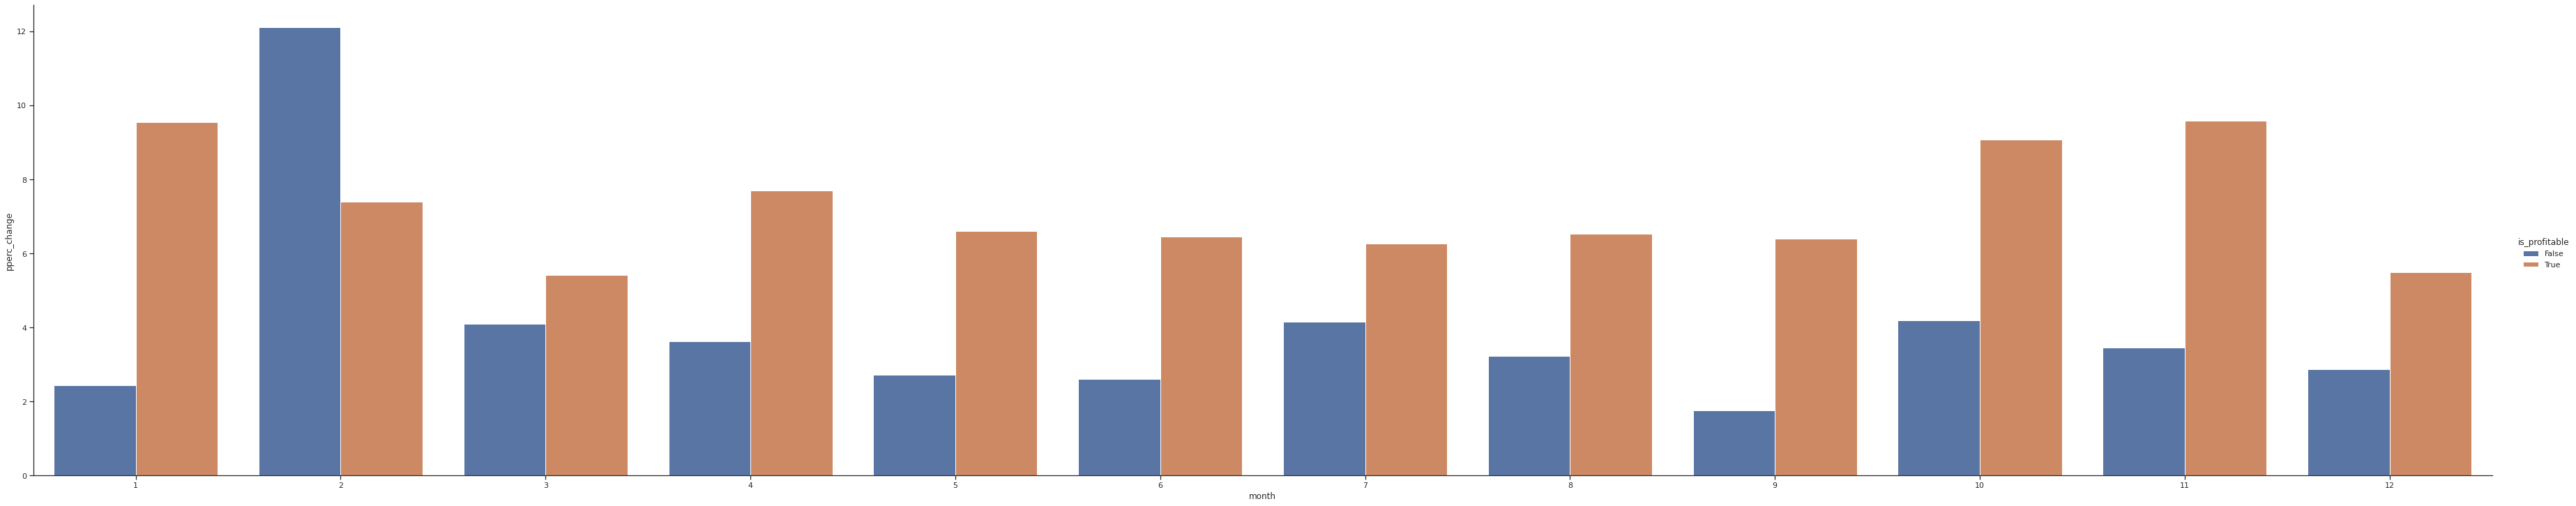

In [64]:
import seaborn as sns

sns.set_theme(style="ticks")
g = sns.catplot(
    x="month",
    y="pperc_change",
    hue="is_profitable",
    kind="bar",
    ci=None,
    data=df[df["year"] >= 15].sort_values("date"),
    height=10,
    aspect=5,
)

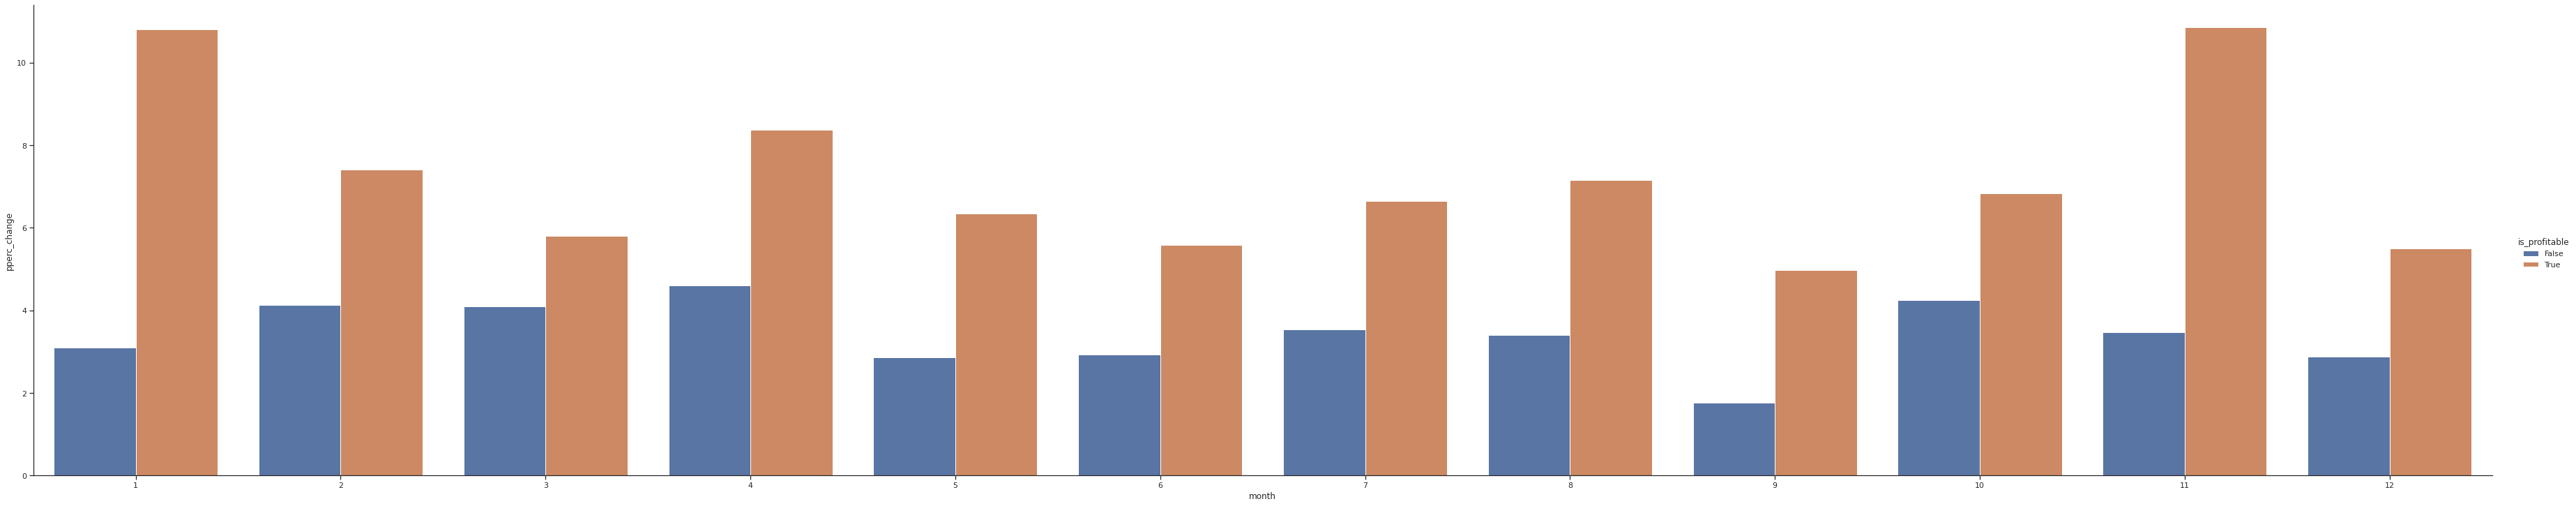

In [72]:
import seaborn as sns

sns.set_theme(style="ticks")
g = sns.catplot(
    x="month",
    y="pperc_change",
    hue="is_profitable",
    kind="bar",
    ci=None,
    data=df[df["year"] > 15][df[df["year"] > 15]["year"] < 20].sort_values("date"),
    height=10,
    aspect=5,
)

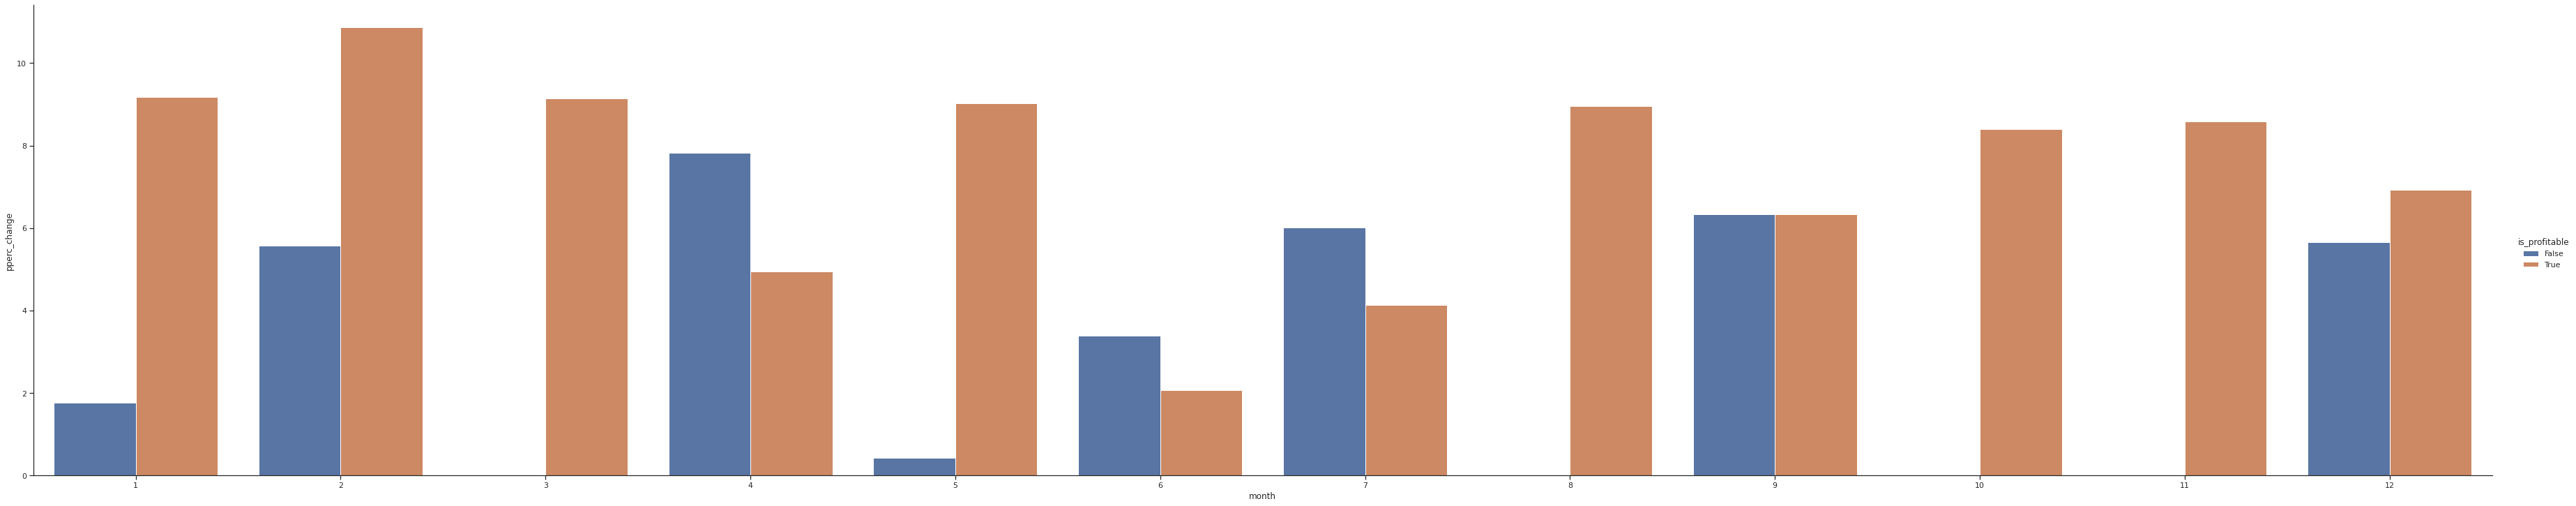

In [78]:
import seaborn as sns

sns.set_theme(style="ticks")
g = sns.catplot(
    x="month",
    y="pperc_change",
    hue="is_profitable",
    kind="bar",
    ci=None,
    data=df[df["year"] == 4].sort_values("date"),
    height=10,
    aspect=5,
)

### Automated pattern finder

In [21]:
def outcome_computation(x):
    l = []
    for _, perc_change in x.sort_values(["date"])["perc_change"].iteritems():
        l.append(perc_change)

    results = []
    for i in range(len(l)):
        res = 1
        for j in range(i, len(l)):
            res += (res * l[j]) / 100
        results.append(res)

    if len(results):
        return sum(results) / len(results)
    else:
        return 0

In [22]:
metrics_options = ["adx", "mdi", "pdi", "ppo", "stochastic"]
size_options = [8, 16, 32, 64, 128, 256, 512]

In [25]:
upper_barrier_results = []

for metric in metrics_options:
    for size in size_options:
        indicator = f"{metric}{size}"
        max_val, min_val = int(df[indicator].max()), int(df[indicator].min())

        for barrier in range(min_val, max_val, 2):
            filtered_df = df[df[indicator] <= barrier]
            outcome = outcome_computation(filtered_df)
            upper_barrier_results.append([metric, size, barrier, outcome])

In [27]:
import numpy as np

upper_barrier_df = pd.DataFrame(
    np.array(upper_barrier_results), columns=["indicator", "period", "barrier", "value"]
)

In [34]:
upper_barrier_df.sort_values("value", ascending=False)

,indicator,period,barrier,value
1030,stochastic,512,78,9964181.170926562
5,adx,8,21,9726.987883327947
109,adx,256,4,9651.263726187311
195,mdi,128,20,95740.57617621447
497,ppo,64,7,9567689177.961262
...,...,...,...,...
958,stochastic,256,28,0
759,stochastic,8,0,0
793,stochastic,16,1,0
828,stochastic,32,0,0


In [49]:
calculate_profitability(df[df["stochastic512"] <= 78])

78.6144578313253

In [35]:
lower_barrier_results = []

for metric in metrics_options:
    for size in size_options:
        indicator = f"{metric}{size}"
        max_val, min_val = int(df[indicator].max()), int(df[indicator].min())

        for barrier in range(min_val, max_val, 2):
            filtered_df = df[df[indicator] >= barrier]
            outcome = outcome_computation(filtered_df)
            lower_barrier_results.append([metric, size, barrier, outcome])

In [37]:
lower_barrier_df = pd.DataFrame(
    np.array(lower_barrier_results), columns=["indicator", "period", "barrier", "value"]
)

In [38]:
lower_barrier_df.sort_values("value", ascending=False)

,indicator,period,barrier,value
1033,stochastic,512,84,9840961183640.54
985,stochastic,256,82,96638812459.37413
774,stochastic,8,30,95426.26205791725
1036,stochastic,512,90,95411.95522060513
849,stochastic,32,42,9393839442917762.0
...,...,...,...,...
574,ppo,256,31,0.9510729613733906
573,ppo,256,29,0.9510729613733906
572,ppo,256,27,0.9510729613733906
199,mdi,128,28,0.9510729613733906


In [48]:
calculate_profitability(df[df["stochastic512"] >= 84])

82.90713324360699

In [40]:
middle_barriers_results = []

# TODO: add a progress bar here
for metric in metrics_options:
    for size in size_options:
        indicator = f"{metric}{size}"
        max_val, min_val = int(df[indicator].max()), int(df[indicator].min())

        for lower_barrier in range(min_val, max_val, 2):
            for upper_barrier in range(lower_barrier, max_val, 2):
                filtered_df = df[
                    (df[indicator] >= lower_barrier) & (df[indicator] <= upper_barrier)
                ]
                outcome = outcome_computation(filtered_df)
                middle_barriers_results.append(
                    [metric, size, lower_barrier, upper_barrier, outcome]
                )

In [41]:
middle_barriers_df = pd.DataFrame(
    np.array(middle_barriers_results),
    columns=["indicator", "period", "lower_barrier", "upper_barrier", "value"],
)

In [42]:
middle_barriers_df.sort_values("value", ascending=False)

,indicator,period,lower_barrier,upper_barrier,value
31085,stochastic,64,65,91,999960400953.3555
28259,stochastic,8,26,54,9997992.912559139
1070,adx,32,19,31,9984259.881664127
28785,stochastic,16,21,29,9984.80806441258
13005,ppo,512,-5,-1,998.2942835606061
...,...,...,...,...,...
24246,ppo,512,169,209,0
24247,ppo,512,169,211,0
24248,ppo,512,169,213,0
24249,ppo,512,169,215,0


In [47]:
calculate_profitability(df[(df["stochastic64"] >= 65) & (df["stochastic64"] <= 91)])

82.44047619047619

In [ ]:
### N pairs pattern finding

In [ ]:
999960400953.3555
9840961183640.54
9964181.170926562

## Uncategoriezed, trial and error, strategy optimizations

In [20]:
df[df["is_profitable"] == False]["perc_change"].min()

-31.135531135531142

In [131]:
100 * len(df[df["is_profitable"] == False]) / len(df)

21.346469622331693

In [36]:
df2 = df[df["pdi16"] > 25]
len(df2)

136

In [37]:
len(df2[df2["is_profitable"] == True])

113

In [38]:
113 * 100 / 136

83.08823529411765

In [40]:
calculate_profitability(df[df["pdi16"] >= 25])

83.08823529411765

In [48]:
calculate_profitability(df[df["pdi16"] >= 26])

85.88235294117646

In [63]:
df[df["pdi16"] >= 26][["mdi16", "is_profitable", "perc_change"]]["perc_change"].max()

14.976465554129225

In [54]:
len(df)

15917

In [61]:
df[df["pdi16"] >= 26]

,ticker,date,adx8,adx16,adx32,adx64,adx128,adx256,adx512,mdi8,...,stochastic16,stochastic32,stochastic64,stochastic128,stochastic256,stochastic512,days_ago_close_period,rsi_close_period,perc_change,is_profitable
884,ABT,2018-10-10,33.617781,31.347538,21.654813,12.685775,10.41746,7.569134,4.668537,38.489424,...,41.195795,59.649123,71.393035,79.513064,83.173296,90.545355,1,26.816396,-0.788357,False
885,ABT,2018-10-10,33.617781,31.347538,21.654813,12.685775,10.41746,7.569134,4.668537,38.489424,...,41.195795,59.649123,71.393035,79.513064,83.173296,90.545355,2,41.536334,1.015767,True
886,ABT,2018-10-10,33.617781,31.347538,21.654813,12.685775,10.41746,7.569134,4.668537,38.489424,...,41.195795,59.649123,71.393035,79.513064,83.173296,90.545355,3,37.157906,0.090964,True
887,ABT,2018-10-10,33.617781,31.347538,21.654813,12.685775,10.41746,7.569134,4.668537,38.489424,...,41.195795,59.649123,71.393035,79.513064,83.173296,90.545355,4,55.949292,3.365676,True
888,ABT,2018-10-10,33.617781,31.347538,21.654813,12.685775,10.41746,7.569134,4.668537,38.489424,...,41.195795,59.649123,71.393035,79.513064,83.173296,90.545355,5,50.442576,2.319588,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15266,AMT,2012-08-23,16.746103,20.140533,18.354081,12.187728,5.91508,2.818974,1.949185,27.162507,...,2.546897,15.798319,55.781112,60.174881,79.220241,81.232163,13,68.209120,3.964086,True
15267,AMT,2012-08-23,16.746103,20.140533,18.354081,12.187728,5.91508,2.818974,1.949185,27.162507,...,2.546897,15.798319,55.781112,60.174881,79.220241,81.232163,14,76.156324,5.166864,True
15268,AMT,2012-08-23,16.746103,20.140533,18.354081,12.187728,5.91508,2.818974,1.949185,27.162507,...,2.546897,15.798319,55.781112,60.174881,79.220241,81.232163,15,51.080299,3.100119,True
15269,AMT,2012-08-23,16.746103,20.140533,18.354081,12.187728,5.91508,2.818974,1.949185,27.162507,...,2.546897,15.798319,55.781112,60.174881,79.220241,81.232163,16,48.965808,2.862951,True


In [65]:
df[df["pdi16"] >= 26].drop_duplicates(subset=["date"], keep="last")

,ticker,date,adx8,adx16,adx32,adx64,adx128,adx256,adx512,mdi8,...,stochastic16,stochastic32,stochastic64,stochastic128,stochastic256,stochastic512,days_ago_close_period,rsi_close_period,perc_change,is_profitable
900,ABT,2018-10-10,33.617781,31.347538,21.654813,12.685775,10.417460,7.569134,4.668537,38.489424,...,41.195795,59.649123,71.393035,79.513064,83.173296,90.545355,0,62.052014,2.258945,True
7173,AKAM,2019-05-13,26.391807,25.587068,19.213458,10.135958,6.573762,4.476163,2.760852,31.332368,...,10.197947,36.828487,47.021783,63.989429,63.989429,74.851549,0,57.770619,5.010074,True
8329,ALB,2016-06-27,37.619292,41.364747,36.154262,20.579467,9.909215,4.974314,2.480283,49.282163,...,40.674226,55.733369,77.202324,86.326641,87.769959,87.769959,0,51.091478,11.852803,True
9570,ALXN,2013-08-16,33.023599,33.574789,24.493061,13.011342,7.504005,7.894443,8.256729,39.721415,...,12.184514,41.619905,51.595928,57.327553,57.327553,76.351835,0,70.748577,9.276190,True
15270,AMT,2012-08-23,16.746103,20.140533,18.354081,12.187728,5.915080,2.818974,1.949185,27.162507,...,2.546897,15.798319,55.781112,60.174881,79.220241,81.232163,0,47.834310,2.744367,True


In [83]:
calculate_profitability(
    df[df["pdi16"] >= 26].drop_duplicates(subset=["date"], keep="last")
)

100.0

In [90]:
calculate_profitability(df[df["rsi_close_period"] >= 70])

100.0

In [92]:
df[df["rsi_close_period"] >= 70].drop_duplicates(subset=["date"], keep="last")

,ticker,date,maperiod,rsi_open_period,adx8,adx16,adx32,adx64,adx128,adx256,...,stochastic16,stochastic32,stochastic64,stochastic128,stochastic256,stochastic512,days_ago_close_period,rsi_close_period,perc_change,is_profitable
305,MMM,2013-08-21,256,8,33.768560,20.180895,17.559259,18.380366,11.660503,5.439684,...,3.577902,42.855133,65.063118,76.621005,87.601405,92.122471,0,77.613835,5.115673,True
339,ABT,2004-08-09,256,8,26.930774,21.200635,12.097110,8.046202,4.658084,3.140872,...,16.661114,8.392641,6.843267,52.154195,59.924027,69.878658,0,76.761167,9.706362,True
356,ABT,2004-10-07,256,8,29.481920,31.920996,20.377997,11.400652,5.895820,3.243559,...,19.926293,46.353414,74.472574,85.279805,86.600221,91.490858,0,71.784917,4.087812,True
368,ABT,2005-01-31,256,8,27.459663,17.058850,17.439340,14.673723,8.732116,4.065417,...,7.058960,40.106899,60.682202,73.824131,81.805259,86.708204,12,70.652692,4.052198,True
387,ABT,2005-03-17,256,8,36.275971,16.639564,10.814955,12.222217,8.895020,4.327746,...,19.706226,26.869301,38.600728,65.748031,81.449893,86.299213,14,79.034079,8.611111,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15660,AWK,2014-08-05,256,8,29.552163,18.770250,24.928044,23.580993,16.440664,11.903484,...,18.369694,16.130269,43.202371,74.694590,80.352304,85.867446,16,71.161628,8.818472,True
15678,AWK,2014-10-02,256,8,36.509470,20.968753,16.507784,19.780472,16.803987,12.532136,...,15.074609,11.184012,45.192308,59.667819,77.864078,84.641659,0,73.222145,7.863572,True
15795,AWK,2017-06-29,256,8,29.233403,20.296133,14.208771,8.860348,6.436156,7.939598,...,26.800246,56.174439,56.174439,73.505612,71.353040,88.572524,15,78.717466,4.890411,True
15848,AWK,2018-09-26,256,8,27.154982,13.002150,8.257768,5.944336,4.542133,4.975094,...,12.284288,11.584254,50.266810,74.979356,73.785762,82.854656,0,70.672886,7.015414,True


In [94]:
calculate_profitability(df[df["adx512"] >= 17])

86.76470588235294

In [95]:
len(df[df["adx512"] >= 17])

68

In [107]:
calculate_profitability(df[df["adx256"] < 15])

58.07616754324821

In [108]:
df[df["adx512"] >= 17].drop_duplicates(subset=["date"], keep="last")

,ticker,date,maperiod,rsi_open_period,adx8,adx16,adx32,adx64,adx128,adx256,...,stochastic16,stochastic32,stochastic64,stochastic128,stochastic256,stochastic512,days_ago_close_period,rsi_close_period,perc_change,is_profitable
6544,AKAM,2004-02-04,256,8,35.609373,26.599899,29.904372,26.231762,14.904929,14.668927,...,7.143035,36.630636,62.007457,76.712329,80.174927,81.032078,0,63.135702,40.087336,True
6561,AKAM,2004-03-23,256,8,30.747530,18.055418,22.812217,24.935856,16.559317,13.217270,...,16.711057,36.620386,51.579130,77.614138,80.575080,81.474711,0,45.087879,10.488959,True
6578,AKAM,2004-04-30,256,8,25.694870,13.741141,12.803564,19.122255,15.767047,12.267348,...,7.190559,18.043535,23.000584,60.969014,70.363926,73.207394,0,77.958420,27.871622,True
6595,AKAM,2004-07-19,256,8,44.464645,24.884338,15.259130,15.278644,14.978340,10.341553,...,12.029242,12.029242,40.078201,43.319464,73.202186,77.182207,0,35.130426,-8.231926,False


In [121]:
a, b = 15.5, 16
calculate_profitability(df[(df["adx128"] < b) & (df["adx128"] > a)])

76.01809954751131

In [124]:
df[(df["adx128"] < b) & (df["adx128"] > a)].drop_duplicates(
    subset=["date"], keep="last"
)

,ticker,date,maperiod,rsi_open_period,adx8,adx16,adx32,adx64,adx128,adx256,...,stochastic16,stochastic32,stochastic64,stochastic128,stochastic256,stochastic512,days_ago_close_period,rsi_close_period,perc_change,is_profitable
866,ABT,2018-02-08,256,8,44.383592,36.174317,30.506676,26.260845,15.947618,7.482334,...,13.349740,19.912132,36.733333,60.801322,71.717289,77.926387,0,61.907908,8.189655,True
1716,ACN,2007-08-10,256,8,30.793638,19.350078,16.123476,18.349827,15.693947,8.952050,...,19.798829,19.641084,38.877481,60.044743,76.942938,80.906564,0,56.083819,4.445187,True
3501,ADBE,2013-12-12,256,8,33.424770,20.947710,19.414443,20.086278,15.938326,7.993656,...,12.088304,31.697342,67.878179,78.589744,85.523116,89.538151,0,52.101722,9.094277,True
5541,A,2004-03-23,256,8,37.182919,26.014525,25.925047,27.010920,15.725028,4.402170,...,12.462433,8.521594,22.663936,47.341611,65.390249,68.459191,0,33.224061,4.257703,True
6459,APD,2014-09-09,256,8,27.320101,14.385908,17.354398,18.231442,15.952574,9.555097,...,18.872513,21.725891,70.688858,76.991472,85.660606,91.585374,0,35.702726,-1.502439,False
6578,AKAM,2004-04-30,256,8,25.694870,13.741141,12.803564,19.122255,15.767047,12.267348,...,7.190559,18.043535,23.000584,60.969014,70.363926,73.207394,0,77.958420,27.871622,True
9196,ALXN,2006-04-11,256,8,30.015487,24.150987,31.493517,23.328127,15.555853,8.527853,...,7.333725,4.347117,69.282361,71.570453,71.570453,76.973353,0,39.575131,-1.083032,False
9519,ALXN,2011-08-08,256,8,48.035426,34.040719,19.475252,17.511574,15.892106,10.310612,...,12.002744,40.113364,40.113364,47.435897,71.421140,76.202603,0,75.735905,20.603538,True
9842,ALGN,2014-01-27,256,8,32.778907,23.166080,21.896746,22.204594,15.559101,9.418996,...,41.125717,52.562028,55.848394,74.803037,84.846172,85.983053,0,32.590450,-3.445787,False
13157,AEP,2007-05-10,256,8,21.851256,18.557235,22.464065,23.370000,15.559737,7.378945,...,29.191534,52.073700,78.751014,86.417833,92.285041,92.305433,0,23.701552,-4.506438,False


In [21]:
a, b = 40, 60
calculate_profitability(df[(df["adx8"] < b) & (df["adx8"] > a)])

76.98412698412699

In [23]:
a, b = 16, 50
calculate_profitability(df[(df["pdi8"] < b) & (df["pdi8"] > a)])

73.57910906298002

In [39]:
a, b = 60, 100
calculate_profitability(df[(df["stochastic128"] < b) & (df["stochastic128"] > a)])

62.929475587703436